# Dimension Reduction in [Bayer and Luetticke (2018)](https://cepr.org/active/publications/discussion_papers/dp.php?dpno=13071)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/HARK/BayerLuetticke?filepath=notebooks%2FHARK%2FBayerLuetticke%2FTwoAsset.ipynb)


This is an accompany to the [main notebook](TwoAsset.ipynb) illustrating dimension reduction in Bayer/Luetticke algorithm.

- Based on original slides by Christian Bayer and Ralph Luetticke 
- Original Jupyter notebook by Seungcheol Lee 
- Further edits by Chris Carroll, Tao Wang 


In [1]:
# Setup stuff

# This is a jupytext paired notebook that autogenerates a corresponding .py file
# which can be executed from a terminal command line via "ipython [name].py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline') 
else:
    get_ipython().run_line_magic('matplotlib', 'auto') 
    
# The tools for navigating the filesystem
import sys
import os

# Find pathname to this file:
my_file_path = os.path.dirname(os.path.abspath("TwoAsset.ipynb"))

# Relative directory for pickled code
code_dir = os.path.join(my_file_path, "BayerLuetticke_code/TwoAssetCode") 

sys.path.insert(0, code_dir)
sys.path.insert(0, my_file_path)

In [2]:
# Change working folder and load Stationary equilibrium (StE)

import pickle
os.chdir(code_dir) # Go to the directory with pickled code

## EX3SS_20.p is the information in the stationary equilibrium 
## (20: the number of illiquid and liquid weath gridpoints)
### The comments above are original, but it seems that there are 30 not 20 points now

EX3SS=pickle.load(open("EX3SS_20.p", "rb"))

### Dimension Reduction via discrete cosine transformation and a fixed copula

#### What is it whose dimension needs to be reduced?

1. Policy and value functions
1. The distribution of agents across states

Grids are constructed for values of the state variables:
  * liquid ($nm$ points), illiquid assets ($nk$), and idiosyncratic pty ($nh$)

So there are $nm \times nk \times nh$ potential combinations

In principle, functions are represented by specifying their values at each specified combination of gridpoints and interpolating for intermediate values
  * In practice, for technical reasons, interpolation is not necessary here

There are two kinds of functions:
1. Policy functions and marginal value functions
   * At each of the gridpoints, there is a number
      * This is value for the value function
      * This is consumption for the consumption function
   * $c_n$ is the consumption function for the nonadjuster
   * $c_a$ is the consumption function for the adjuster
1. The distribution (="histograms") of agents across states
   * In principle, distributions need not be computed at the same gridpoints used to represent the value and policy functions
   * In practice, the same grids are used

In [3]:
# Recover dimensions of the marginal value and consumption functions

print('c_n is of dimension: ' + str(EX3SS['mutil_c_n'].shape))
print('c_a is of dimension: ' + str(EX3SS['mutil_c_a'].shape))

print('Vk is of dimension:' + str(EX3SS['Vk'].shape))
print('Vm is of dimension:' + str(EX3SS['Vm'].shape))

print('For convenience, these are all constructed from the same exogenous grids:')
print(str(len(EX3SS['grid']['m']))+' gridpoints for liquid assets;')
print(str(len(EX3SS['grid']['k']))+' gridpoints for illiquid assets;')
print(str(len(EX3SS['grid']['h']))+' gridpoints for individual productivity.')
print('')
print('Therefore, the joint distribution across different is of size: ')
print(str(EX3SS['mpar']['nm'])+
      ' * '+str(EX3SS['mpar']['nk'])+
      ' * '+str(EX3SS['mpar']['nh'])+
      ' = '+ str(EX3SS['mpar']['nm']*EX3SS['mpar']['nk']*EX3SS['mpar']['nh']))
      


c_n is of dimension: (30, 30, 4)
c_a is of dimension: (30, 30, 4)
Vk is of dimension:(30, 30, 4)
Vm is of dimension:(30, 30, 4)
For convenience, these are all constructed from the same exogenous grids:
30 gridpoints for liquid assets;
30 gridpoints for illiquid assets;
4 gridpoints for individual productivity.

Therefore, the joint distribution across different is of size: 
30 * 30 * 4 = 3600


#### Intuitively, how does the reduction work?

##### Reducing the dimension of policy/value functions
- The first step is to find an efficient "compressed" representation of the function (e.g., the consumption function).  The analogy to image compression is that nearby pixels are likely to have identical or very similar colors, so we need only to find an efficient way to represent the way in which the colors change from one pixel to another.  Similarly, consumption at a given point is likely to be close to consumption at a nearby point, so a function that captures that similarity efficiently can preserve most of the information without keeping all of the points.

- We will be using the discrete cosine transformation (DCT), which is commonly used in image compression. See [here](https://en.wikipedia.org/wiki/Discrete_cosine_transform) for the Wikipedia page on DCT. 

##### Reducing the dimension of joint distribution

- The other tool we use is the "copula," which allows us to represent the distribution of people across idiosyncratic states efficiently
   * In general, a multivariate joint distribution is not uniquely determined by marginal distributions only. A copula, to put it simply, characterizes the correlation across variables and it combined with marginal distributions  determine the unique joint distribution.  
   * The crucial assumption of fixed copula is that what aggregate shocks do is to squeeze or distort the steady state distribution, but leave the rank structure of the distribution the same. Think of representing a balloon by a set of points on its surface; the copula assumption is effectively that when something happens to the balloon (more air is put in it, or it is squeezed on one side, say), we can represent what happens by thinking about how the relationship between points is distorted, rather than having to reconstruct the shape of the balloon with a completely independent set of new points.  Which points are close to which other points does not change, but the distances between them can change.  If the distances between them change in a particularly simple way, you can represent what has happened with a small amount of information.  For example, if the balloon is perfectly spherical, then adding a given amount of air might increase the distances between adjacent points by 5 percent.  (See the video illustration here)

- In the context of this model, the assumption is that the rank order correlation (e.g. the correlation of where you are in the distribution of liquid assets and illiquid assets) remains the same after the aggregate shocks are introduced to StE

- In this case we just need to represent how the marginal distributions of each state change, instead of the full joint distributions. 

- This reduces 3600 to 30+30+4=64. See [here](https://en.wikipedia.org/wiki/Copula_(probability_theory)) for the Wikipedia page on copula. The copula is computed from the joint distribution of states in StE and will be used to transform the marginals back to joint distributions.

In [4]:
# Get some specs about the copula, which is precomputed in the EX3SS object

print('The copula consists of two parts: gridpoints and values at those gridpoints:'+ \
      ',\n gridpoints with dimension of '+str(EX3SS['Copula']['grid'].shape) + \
      ', where the first element is total number of gridpoints' + \
      ', and the second element is number of states' + \
     ',\n and values with dimension of '+str(EX3SS['Copula']['value'].shape) + \
      ', \n each entry of which is the probability of the three state variables below the grids.')

The copula consists of two parts: gridpoints and values at those gridpoints:,
 gridpoints with dimension of (3600, 3), where the first element is total number of gridpoints, and the second element is number of states,
 and values with dimension of (3600,), 
 each entry of which is the probability of the three state variables below the grids.


In [5]:
## Import necessary libraries

from __future__ import print_function
import sys 
sys.path.insert(0,'../')

import numpy as np
from numpy.linalg import matrix_rank
import scipy as sc
from scipy.stats import norm 
from scipy.interpolate import interp1d, interp2d, griddata, RegularGridInterpolator, interpn
import multiprocessing as mp
from multiprocessing import Pool, cpu_count, Process
from math import ceil
import math as mt
from scipy import sparse as sp  # used to work with sparse matrices
from scipy import linalg   #linear algebra 
from math import log, cos, pi, sqrt
import time
from SharedFunc3 import Transition, ExTransitions, GenWeight, MakeGridkm, Tauchen, Fastroot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.io #scipy input and output
import scipy.fftpack as sf  # scipy discrete fourier transforms

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [6]:
## State reduction and discrete cosine transformation

class StateReduc_Dct:
    
    def __init__(self, par, mpar, grid, Output, targets, Vm, Vk, 
                 joint_distr, Copula, c_n_guess, c_a_guess, psi_guess,
                 m_n_star, m_a_star, cap_a_star, mutil_c_n, mutil_c_a,mutil_c, P_H):
         
        self.par = par         # Parameters of the theoretical model
        self.mpar = mpar       # Parameters of the numerical representation
        self.grid = grid       # Discrete grid
        self.Output = Output   # Results of the calculations
        self.targets = targets # Like, debt-to-GDP ratio or other desiderata
        self.Vm = Vm           # Marginal value from liquid cash-on-hand
        self.Vk = Vk           # Marginal value of capital
        self.joint_distr = joint_distr # Multidimensional histogram
        self.Copula = Copula   # Encodes rank correlation structure of distribution
        self.mutil_c = mutil_c # Marginal utility of consumption
        self.P_H = P_H         # Transition matrix for macro states (not including distribution)
        
        
    def StateReduc(self):
        """
        input
        -----
        self: dict, stored results from a StE 
        
        output
        ------
        Newly generated
        ===============
        X_ss: ndarray, stacked states, including  
        Y_ss:  ndarray, controls 
        Gamma_state: ndarray, marginal distributions of individual states 
        grid: ndarray, discrete grids
        targets: ndarray, debt-to-GDP ratio or other desiderata
        P_H: transition probability of
        indexMUdct: ndarray, indices selected after dct operation on marginal utility of consumption
        indexVKdct: ndarray, indices selected after dct operation on marginal value of capital
        State: ndarray, dimension equal to reduced states
        State_m: ndarray, dimension equal to reduced states
        Contr:  ndarray, dimension equal to reduced controls
        Contr_m: ndarray, dimension equal to reduced controls
        
        Passed down from the input
        ==========================
        Copula: dict, grids and values
        joint_distr: ndarray, nk x nm x nh
        Output: dict, outputs from the model 
        par: dict, parameters of the theoretical model
        mpar:dict, parameters of the numerical representation
        aggrshock: string, type of aggregate shock used to purturb the StE 
        """
        
        # Inverse of CRRA on x for utility and marginal utility
        invutil = lambda x : ((1-self.par['xi'])*x)**(1./(1-self.par['xi'])) 
        invmutil = lambda x : (1./x)**(1./self.par['xi'])                    
            
        # X=States
        # Marg dist of liquid assets summing over pty and illiquid assets k
        Xss=np.asmatrix(np.concatenate((np.sum(np.sum(self.joint_distr.copy(),axis=1),axis =1),  
                       np.transpose(np.sum(np.sum(self.joint_distr.copy(),axis=0),axis=1)),# marg dist k
                       np.sum(np.sum(self.joint_distr.copy(),axis=1),axis=0), # marg dist pty (\approx income)
                       [np.log(self.par['RB'])],[ 0.]))).T # Given the constant interest rate
        
        # Y="controls" (according to this literature's odd terminology)
        # c = invmarg(marg(c)), so first bit gets consumption policy function
        Yss=np.asmatrix(np.concatenate((invmutil(self.mutil_c.copy().flatten(order = 'F')),\
                                        invmutil(self.Vk.copy().flatten(order = 'F')),
                      [np.log(self.par['Q'])], # Question: Price of the illiquid asset, right?
                                        [ np.log(self.par['PI'])], # Inflation
                                        [ np.log(self.Output)],    
                      [np.log(self.par['G'])], # Gov spending
                                        [np.log(self.par['W'])], # Wage
                                        [np.log(self.par['R'])], # Nominal R
                                        [np.log(self.par['PROFITS'])], 
                      [np.log(self.par['N'])], # Hours worked
                                        [np.log(self.targets['T'])], # Taxes
                                        [np.log(self.grid['K'])],    # Kapital
                      [np.log(self.targets['B'])]))).T # Government debt
        
        # Mapping for Histogram
        # Gamma_state matrix reduced set of states
        #   nm = number of gridpoints for liquid assets
        #   nk = number of gridpoints for illiquid assets
        #   nh = number of gridpoints for human capital (pty)
        Gamma_state = np.zeros( # Create zero matrix of size [nm + nk + nh,nm + nk + nh - 4]
            (self.mpar['nm']+self.mpar['nk']+self.mpar['nh'],
             self.mpar['nm']+self.mpar['nk']+self.mpar['nh'] - 4)) 
            # Question: Why 4? 4 = 3+1, 3: sum to 1 for m, k, h and 1: for entrepreneurs 

        # Impose adding-up conditions: 
        # In each of the block matrices, probabilities must add to 1
        
        for j in range(self.mpar['nm']-1): # np.squeeze reduces one-dimensional matrix to vector
            Gamma_state[0:self.mpar['nm'],j] = -np.squeeze(Xss[0:self.mpar['nm']])
            Gamma_state[j,j]=1. - Xss[j]   #   
            Gamma_state[j,j]=Gamma_state[j,j] - np.sum(Gamma_state[0:self.mpar['nm'],j])
        bb = self.mpar['nm'] # Question: bb='bottom base'? because bb shorter to type than self.mpar['nm'] everywhere

        for j in range(self.mpar['nk']-1):
            Gamma_state[bb+np.arange(0,self.mpar['nk'],1), bb+j-1] = -np.squeeze(Xss[bb+np.arange(0,self.mpar['nk'],1)])
            Gamma_state[bb+j,bb-1+j] = 1. - Xss[bb+j] 
            Gamma_state[bb+j,bb-1+j] = (Gamma_state[bb+j,bb-1+j] - 
                                        np.sum(Gamma_state[bb+np.arange(0,self.mpar['nk']),bb-1+j]))
        bb = self.mpar['nm'] + self.mpar['nk']

        for j in range(self.mpar['nh']-2): 
            # Question: Why -2?  1 for h sum to 1 and 1 for entrepreneur  Some other symmetry/adding-up condition.
            Gamma_state[bb+np.arange(0,self.mpar['nh']-1,1), bb+j-2] = -np.squeeze(Xss[bb+np.arange(0,self.mpar['nh']-1,1)])
            Gamma_state[bb+j,bb-2+j] = 1. - Xss[bb+j]
            Gamma_state[bb+j,bb-2+j] = Gamma_state[bb+j,bb-2+j] - np.sum(Gamma_state[bb+np.arange(0,self.mpar['nh']-1,1),bb-2+j])

        # Number of other state variables not including the gridded -- here, just the interest rate 
        self.mpar['os'] = len(Xss) - (self.mpar['nm']+self.mpar['nk']+self.mpar['nh'])
        # For each gridpoint there are two "regular" controls: consumption and illiquid saving
        # Counts the number of "other" controls (PROFITS, Q, etc)
        self.mpar['oc'] = len(Yss) - 2*(self.mpar['nm']*self.mpar['nk']*self.mpar['nh'])
        
        aggrshock = self.par['aggrshock']
        accuracy = self.par['accuracy']
       
        # Do the dct on the steady state marginal utility
        # Returns an array of indices for the used basis vectors
        indexMUdct = self.do_dct(invmutil(self.mutil_c.copy().flatten(order='F')),
                                 self.mpar,accuracy)

        # Do the dct on the steady state marginal value of capital
        # Returns an array of indices for the used basis vectors
        indexVKdct = self.do_dct(invmutil(self.Vk.copy()),self.mpar,accuracy)
                
        # Calculate the numbers of states and controls
        aux = np.shape(Gamma_state)
        self.mpar['numstates'] = np.int64(aux[1] + self.mpar['os'])
        self.mpar['numcontrols'] = np.int64(len(indexMUdct) + 
                                            len(indexVKdct) + 
                                            self.mpar['oc'])
        
        # Size of the reduced matrices to be used in the Fsys
        # Set to zero because in steady state they are zero
        State = np.zeros((self.mpar['numstates'],1))
        State_m = State
        Contr = np.zeros((self.mpar['numcontrols'],1))
        Contr_m = Contr
        
        return {'Xss': Xss, 'Yss':Yss, 'Gamma_state': Gamma_state, 
                'par':self.par, 'mpar':self.mpar, 'aggrshock':aggrshock,
                'Copula':self.Copula,'grid':self.grid,'targets':self.targets,'P_H':self.P_H, 
                'joint_distr': self.joint_distr, 'Output': self.Output, 'indexMUdct':indexMUdct, 'indexVKdct':indexVKdct,
                'State':State, 'State_m':State_m, 'Contr':Contr, 'Contr_m':Contr_m}

    # Discrete cosine transformation magic happens here
    # sf is scipy.fftpack tool
    def do_dct(self, obj, mpar, level):
        """
        input
        -----
        obj: ndarray nm x nk x nh  
             dimension of states before dct 
        mpar: dict
            parameters in the numerical representaion of the model, e.g. nm, nk and nh
        level: float 
               accuracy level for dct 
        output
        ------
        index_reduced: ndarray n_dct x 1 
                       an array of indices that select the needed grids after dct
                   
        """
        obj = np.reshape(obj.copy(),(mpar['nm'],mpar['nk'],mpar['nh']),order='F')
        X1 = sf.dct(obj,norm='ortho',axis=0)    # dct is operated along three dimensions axis=0/1/2
        X2 = sf.dct(X1.copy(),norm='ortho',axis=1)
        X3 = sf.dct(X2.copy(),norm='ortho',axis=2)

        # Pick the coefficients that are big
        XX = X3.flatten(order='F') 
        ind = np.argsort(abs(XX.copy()))[::-1]
        #  i will 
        i = 1    
        # Sort from smallest (=best) to biggest (=worst)
        # and count how many are 'good enough to keep'
        while linalg.norm(XX[ind[:i]].copy())/linalg.norm(XX) < level:
              i += 1    
        
        needed = i # Question:Isn't this counting the ones that are NOT needed?
        
        index_reduced = np.sort(ind[:i]) # Retrieve the good 
        
        return index_reduced

In [7]:
## Choose an aggregate shock to perturb(one of three shocks: MP, TFP, Uncertainty)

EX3SS['par']['aggrshock']           = 'MP'
EX3SS['par']['rhoS']    = 0.0      # Persistence of variance
EX3SS['par']['sigmaS']  = 0.001    # STD of variance shocks

#EX3SS['par']['aggrshock']           = 'TFP'
#EX3SS['par']['rhoS']    = 0.95
#EX3SS['par']['sigmaS']  = 0.0075
    
#EX3SS['par']['aggrshock']           = 'Uncertainty'
#EX3SS['par']['rhoS']    = 0.84    # Persistence of variance
#EX3SS['par']['sigmaS']  = 0.54    # STD of variance shocks

In [8]:
## Choose an accuracy of approximation with DCT
### Determines number of basis functions chosen -- enough to match this accuracy
### EX3SS is precomputed steady-state pulled in above
EX3SS['par']['accuracy'] = 0.99999 

In [9]:
## Implement state reduction and DCT
### Do state reduction on steady state
EX3SR=StateReduc_Dct(**EX3SS)   # Takes StE result as input and get ready to invoke state reduction operation
SR=EX3SR.StateReduc()           # StateReduc is operated 

In [10]:
print('What are the results from the state reduction?')
#print('Newly added attributes after the operation include \n'+str(set(SR.keys())-set(EX3SS.keys())))

print('\n')

print('The dimension of policy function is reduced to '+str(SR['indexMUdct'].shape[0]) \
      +' from '+str(EX3SS['mutil_c'].shape))
print('The dimension of value function is reduced to '+str(SR['indexVKdct'].shape[0]) \
      + ' from ' + str(EX3SS['Vk'].shape))
print('The total number of control variables is '+str(SR['Contr'].shape[0])+'='+str(SR['indexMUdct'].shape[0]) + \
      '+'+str(SR['indexVKdct'].shape[0])+'+ # of other macro controls')
print('\n')
print('After marginalizing the joint distribution, \
      \n the dimension of states including exogenous state, is '+str(SR['Xss'].shape[0]))
print('Dimension of gamma_state is '+str(SR['Gamma_state'].shape)+\
      '. It simply stacks all grids of different\
      \n state variables regardless of their joint distributions.\
      \n This is due to the assumption of the rank order remains the same.')
print('The total number of state variables is '+str(SR['State'].shape[0]) + '='+\
     str(SR['Gamma_state'].shape[1])+'+ # of other states')

What are the results from the state reduction?


The dimension of policy function is reduced to 154 from (30, 30, 4)
The dimension of value function is reduced to 94 from (30, 30, 4)
The total number of control variables is 259=154+94+ # of other macro controls


After marginalizing the joint distribution,       
 the dimension of states including exogenous state, is 66
Dimension of gamma_state is (64, 60). It simply stacks all grids of different      
 state variables regardless of their joint distributions.      
 This is due to the assumption of the rank order remains the same.
The total number of state variables is 62=60+ # of other states


### Graphical Illustration

#### Policy/value functions

- Taking marginal utility as an example, one can plot its values at different grid points in both 2-dimensional and 3-dimensional spaces before and after dimension reduction.   
  -  2-dimensional graph: marginal utility at different grid points of a state variable fixing the values of other two state variables. 
     - For example, how the reduction works for liquid assets for given level of illiquid assets holding and productivity. 

  -  3-dimensional graph: marginal utility at different grids points at grid points of liquid and illiquid assets with only value of productivity fixed. 
     - There is limitations at 1-dimensional graph, as we do not know ex ante at what grid points the dimension is reduced. So the 3-dimensional graph gives us a more complete picture. 
     - In this context, as we only have 4 grid points for productivity, we can fix an arbitrary one of the 4 grids and focus on how the number of grids is reduced for liquid and illiquid assets.
     
#### Marginal distributions

-  We can also graphically show marginal distributions versus joint distribution. 

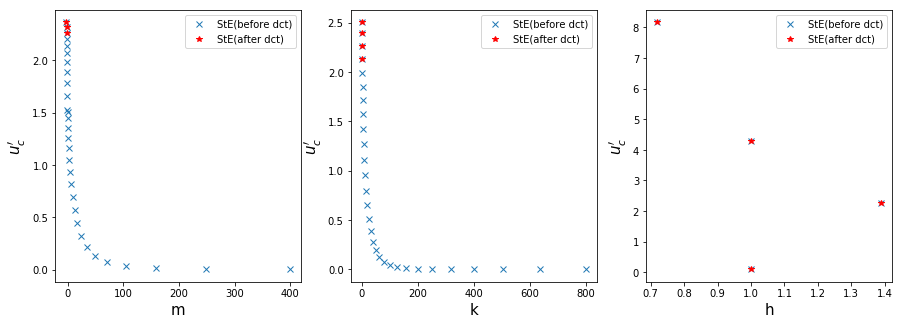

In [11]:
## Graphical illustration

###   In 2D, we can look at how the number of grid points of 
###     one state is redcued at given grid values of other states. 

mgrid_fix = EX3SS['mpar']['nm']//11   # "//" is for floor division unambiguously 
kgrid_fix = EX3SS['mpar']['nk']//11
hgrid_fix = EX3SS['mpar']['nh']//2


mut_StE = EX3SS['mutil_c']
dim_StE = mut_StE.shape
mgrid = EX3SS['grid']['m']
kgrid = EX3SS['grid']['k']
hgrid = EX3SS['grid']['h']

mut_rdc_idx = np.unravel_index(SR['indexMUdct'],dim_StE,order='F')

mgrid_rdc = mut_rdc_idx[0][(mut_rdc_idx[1]==kgrid_fix) & (mut_rdc_idx[2]==hgrid_fix)]
kgrid_rdc = mut_rdc_idx[1][(mut_rdc_idx[0]==mgrid_fix) & (mut_rdc_idx[2]==hgrid_fix)]
hgrid_rdc = mut_rdc_idx[2][(mut_rdc_idx[0]==mgrid_fix) & (mut_rdc_idx[1]==kgrid_fix)]

## compare marginal utility before and after dct 
plt.figure(figsize=(15,5))
plt.title('Marginal utility of consumption at grid points of states')

plt.subplot(1,3,1)
plt.plot(mgrid,mut_StE[:,kgrid_fix,hgrid_fix],'x',label='StE(before dct)')
plt.plot(mgrid[mgrid_rdc],mut_StE[mgrid_rdc,kgrid_fix,hgrid_fix],'r*',label='StE(after dct)')

plt.xlabel('m',size=15)
plt.ylabel(r'$u_c^\prime$',size=15)
plt.legend()

plt.subplot(1,3,2)
plt.plot(kgrid,mut_StE[mgrid_fix,:,hgrid_fix],'x',label='StE(before dct)')
plt.plot(kgrid[kgrid_rdc],mut_StE[mgrid_fix,kgrid_rdc,hgrid_fix],'r*',label='StE(after dct)')
plt.xlabel('k',size=15)
plt.ylabel(r'$u_c^\prime$',size=15)
plt.legend()

plt.subplot(1,3,3)
plt.plot(hgrid,mut_StE[mgrid_fix,kgrid_fix,:],'x',label='StE(before dct)')
plt.plot(hgrid[hgrid_rdc],mut_StE[mgrid_fix,kgrid_fix,hgrid_rdc],'r*',label='StE(after dct)')
plt.xlabel('h',size=15)
plt.ylabel(r'$u_c^\prime$',size=15)
plt.legend()

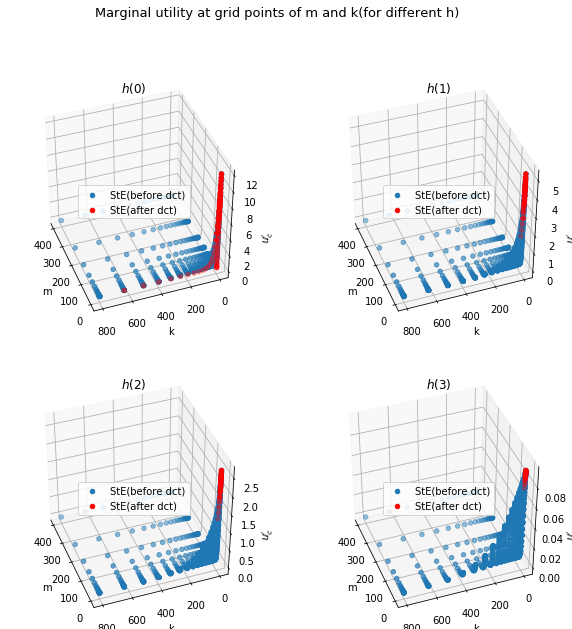

In [12]:
## 3D scatter plots of all grids and grids after dct

## full grids 
mmgrid,kkgrid = np.meshgrid(mgrid,kgrid)

## rdc grids 

fig = plt.figure(figsize=(10,10))
fig.suptitle('Marginal utility at grid points of m and k(for different h)',fontsize=(13))
for hgrid_id in range(EX3SS['mpar']['nh']):
    ## prepare the grids 
    hgrid_fix=hgrid_id
    fix_bool = mut_rdc_idx[2]==hgrid_fix  # for a fixed h grid value 
    rdc_id = (mut_rdc_idx[0][fix_bool], mut_rdc_idx[1][fix_bool],mut_rdc_idx[2][fix_bool])
    mmgrid_rdc = mmgrid[rdc_id[0]].T[0]
    kkgrid_rdc = kkgrid[rdc_id[1]].T[0]
    mut_rdc= mut_StE[rdc_id]
    
    ## plots 
    ax = fig.add_subplot(2,2,hgrid_id+1, projection='3d')
    ax.scatter(mmgrid,kkgrid,mut_StE[:,:,hgrid_fix],label='StE(before dct)')
    ax.scatter(mmgrid_rdc,kkgrid_rdc,mut_rdc,c='red',label='StE(after dct)')
    ax.set_xlabel('m')
    ax.set_ylabel('k')
    ax.set_zlabel(r'$u^\prime_c$')
    ax.set_title(r'$h({})$'.format(hgrid_fix))
    #ax.set_xlim(0, 200)
    #ax.set_ylim(0, 400)
    ax.view_init(40, 160)
    ax.legend(loc=10)

#### Observation

- For a given grid value of productivity, the remaining grid points after DCT to represent the whole m-k surface concentrate on low values of k and m. The reason, to put it simply, is that the slopes of the surface of marginal utility are very steep around this area. 
- For different grid values of productivity(4 sub plots), the numbers of grid points operation differ. From the lowest to highest values of productivity, there are 78, 33, 25 and 18 grid points, respectively. They add up to the total number of grids 154 after DCT operation, as we print out above for marginal utility function. 

### Summary: what do we achieve after the transformation?

- Via DCT, the dimension of policy function and value functions are reduced both from 3600 to 154 and 94, respectively.
- Via marginalizing the joint distribution with the fixed copula assumption, the marginal distribution is of dimension 64 compared to its joint distribution of a dimension of 3600.


